# Duc Huy Nguyen - Statistics DRP Project Autumn 2025
## Relationship between Job Postings and Unemployment
### with related Economics metrics

We first import the required libraries for the project

In [583]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Import some ML models from sklearn
# from sklearn import 

In [584]:
# Suppress irrelevant warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading data and preliminary processing
We then load relevant datasets on job postings, unemployment, interest rates, inflation, stock prices and GDP into our notebook.

In [585]:
cpi_df = pd.read_csv('Data/monthly_cpi.csv') # Read CPI data
gdp_df = pd.read_csv('Data/quarterly_gdp.csv')# Read GDP data
unemp_df = pd.read_csv('Data/monthly_unemployment_rate.csv') # Read Unemployment data
job_df = pd.read_csv('Data/monthly_job_postings.csv')# Read Job Postings
sp500_df = pd.read_csv('Data/monthly_sp500.csv') # Read S&P 500 data
bond_df = pd.read_csv('Data/monthly_bonds.csv') # Read the bonds data
inflation_df = pd.read_csv('Data/monthly_inflation_rate.csv')
interest_df = pd.read_csv('Data/monthly_federal_funds_rate.csv') # Read the interest rates data

We format the time for our Dataframe 

In [586]:
for df in [cpi_df, gdp_df, unemp_df, interest_df, job_df, inflation_df]: # format dates for data got from FRED
    df.rename(columns={'observation_date' : 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

We then format the monthly stock price

In [587]:
for df in [sp500_df, bond_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

We then try to estimate the monthly GDP data using resampling and interpolation in Python.  
We are using linear spline to predict the months within 2025 Q3 without available data (this would be updated by FRED in Nov 26th 2025)

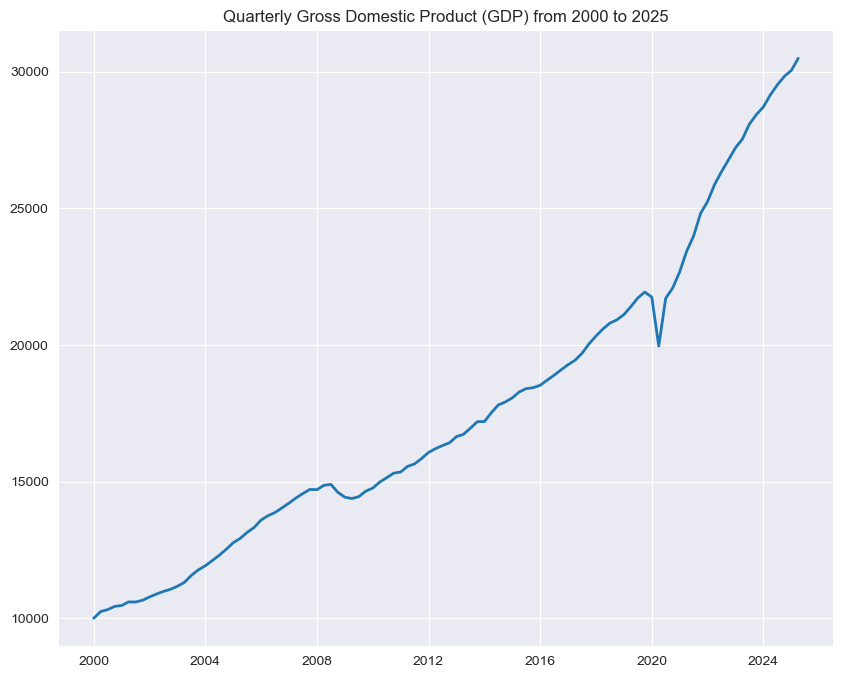

In [588]:
# First we plot the data before interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Quarterly Gross Domestic Product (GDP) from 2000 to 2025')
plt.show()

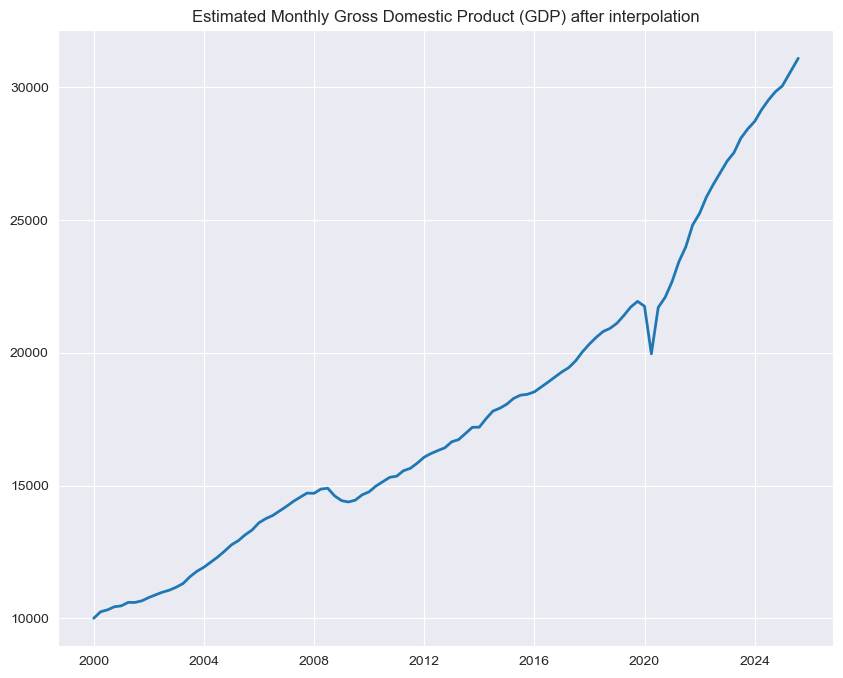

In [589]:
# We extend our current date time into the future
future_dates = pd.to_datetime(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])
extended_index = gdp_df.index.union(future_dates)

# print(extended_index)
gdp_df = gdp_df.reindex(extended_index)

# Then we interpolate the data 
gdp_df = gdp_df.resample('MS')
gdp_df = gdp_df.interpolate(method='spline', order = 1)

# Check the data after interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Estimated Monthly Gross Domestic Product (GDP) after interpolation')
plt.show()

## Data Cleaning and Formatting 

In [590]:
print(cpi_df.head(5))
print(unemp_df.head(5))
print(job_df.head(5))
print(sp500_df.head(5))
print(bond_df.head(5))
print(interest_df.head(5))
print(gdp_df.head(5))
print(sp500_df.index)

            CPIAUCSL
date                
2000-01-01     169.3
2000-02-01     170.0
2000-03-01     171.0
2000-04-01     170.9
2000-05-01     171.2
            UNRATE
date              
2000-01-01     4.0
2000-02-01     4.1
2000-03-01     4.0
2000-04-01     3.8
2000-05-01     4.0
            JTSJOL
date              
2000-12-01    5088
2001-01-01    5234
2001-02-01    5097
2001-03-01    4762
2001-04-01    4615
                  SPY
date                 
1999-08-01  82.999374
1999-09-01  81.145393
1999-10-01  86.345009
1999-11-01  87.782784
1999-12-01  92.795937
                  BND
date                 
2007-04-01  42.318459
2007-05-01  41.985470
2007-06-01  41.854744
2007-07-01  42.240814
2007-08-01  42.867413
            FEDFUNDS
date                
2000-01-01      5.45
2000-02-01      5.73
2000-03-01      5.85
2000-04-01      6.02
2000-05-01      6.27
                     GDP
2000-01-01  10002.179000
2000-02-01  10085.816288
2000-03-01  10163.985130
2000-04-01  10247.720000
2000-05

In [591]:
# Sanity check on the index type
assert (type(job_df.index) == type(sp500_df.index) == type(inflation_df.index)
        == type(cpi_df.index) == type(unemp_df.index)
        == type(gdp_df.index) == type(interest_df.index)
        == type(bond_df.index) == pd.DatetimeIndex)


In [592]:
# Count the number of Nan values
print(cpi_df.isna().sum())
print(unemp_df.isna().sum())
print(job_df.isna().sum())
print(sp500_df.isna().sum())
print(interest_df.isna().sum())
print(bond_df.isna().sum())
print(gdp_df.isna().sum())
print(inflation_df.isna().sum())

CPIAUCSL    0
dtype: int64
UNRATE    0
dtype: int64
JTSJOL    0
dtype: int64
SPY    0
dtype: int64
FEDFUNDS    0
dtype: int64
BND    0
dtype: int64
GDP    0
dtype: int64
T10YIEM    0
dtype: int64


In [593]:
# Include another Dummy Variables for which Party is winning presidency
dates = pd.date_range(start = "2000-10-01", end = "2025-08-01", freq = "MS")

# Determine the presidency 
def president_party(date):
    if (date < pd.Timestamp("2000-01-20")  # Bill Clinton
            or pd.Timestamp("2009-01-20") < date < pd.Timestamp("2017-01-20") # Obama
            or pd.Timestamp("2021-01-20") < date < pd.Timestamp("2025-01-20")): # Biden
        return "Dem"
    else:
        return "Rep"
    
party_df = pd.DataFrame({
    "date": dates,
    "party": [president_party(d) for d in dates]
})

# Dummy variable: 1 = Republican, 0 = Democrat
party_df["party"] = (party_df["party"] == "Rep").astype(int)
party_df.set_index('date', inplace = True)

In [594]:
# Join those data together
joined_df = cpi_df.join(unemp_df, how='right')
joined_df = joined_df.join(gdp_df, how='left')
joined_df = joined_df.join(job_df, how='left')
joined_df = joined_df.join(inflation_df, how='left')
joined_df = joined_df.join(interest_df, how='left')
joined_df = joined_df.join(bond_df, how='right')
joined_df = joined_df.join(sp500_df, how='inner')
joined_df = joined_df.join(party_df, how='left')

In [595]:
# Rename column names for easier use 
joined_df.rename(columns={
    'CPIAUCSL' : 'cpi',
    'UNRATE' : 'unemp',
    'JTSJOL' : 'job_postings',
    'FEDFUNDS' : 'interest_rate',
    'BND' : 'bond',
    'SPY' : 'sp500',
    'T10YIEM' : 'inflation_rate'
}, inplace=True)

## Exploratory Data Analysis

We then examine our datasets before building our machine learning model 

In [596]:
joined_df.head(5)

,cpi,unemp,GDP,job_postings,inflation_rate,interest_rate,bond,sp500,party
date,,,,,,,,,
2007-04-01,205.904,4.5,14402.082000,4689.0,2.43,5.25,42.318459,104.983070,1
2007-05-01,206.755,4.4,14455.504874,4657.0,2.38,5.25,41.985470,108.544159,1
2007-06-01,207.234,4.6,14510.736558,4859.0,2.41,5.25,41.854744,106.957092,1
2007-07-01,207.603,4.7,14564.117000,4598.0,2.36,5.26,42.240814,103.608284,1
2007-08-01,207.667,4.6,14614.954473,4546.0,2.23,5.02,42.867413,104.937889,1


In [597]:
joined_df.tail(5)

,cpi,unemp,GDP,job_postings,inflation_rate,interest_rate,bond,sp500,party
date,,,,,,,,,
2025-04-01,320.321,4.2,30485.729000,7395.0,2.24,4.33,71.843529,551.376831,1
2025-05-01,320.580,4.2,30633.378449,7712.0,2.31,4.33,71.359116,586.028015,1
2025-06-01,321.500,4.1,30786.057742,7357.0,2.30,4.33,72.441345,616.141785,1
2025-07-01,322.132,4.2,30933.811896,7208.0,2.38,4.33,72.248878,630.332458,1
2025-08-01,323.364,4.3,31086.491188,7227.0,2.38,4.33,73.082718,643.266602,1


In [598]:
# Count the number of Nan values
print(joined_df.isna().sum())

cpi               0
unemp             0
GDP               0
job_postings      0
inflation_rate    0
interest_rate     0
bond              0
sp500             0
party             0
dtype: int64


In [599]:
# Total number of observations and date range
print(len(joined_df))
print(joined_df.index)

221
DatetimeIndex(['2007-04-01', '2007-05-01', '2007-06-01', '2007-07-01',
               '2007-08-01', '2007-09-01', '2007-10-01', '2007-11-01',
               '2007-12-01', '2008-01-01',
               ...
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01'],
              dtype='datetime64[ns]', name='date', length=221, freq=None)


Sources: Job Postings (in thousands) - From the Bureau of Labor Statistics  
Bonds prices taken from Vanguard's BND which focus on wide spectrum of bonds - Yahoo Finance  
Federal Fund Rate (the rate at which banks with each other at the end of night) - Federal Reserve Bank of ST.LOUIS  
CPI, Unemployment rate, S&P 500 - Federal Reserve Bank of ST.LOUIS

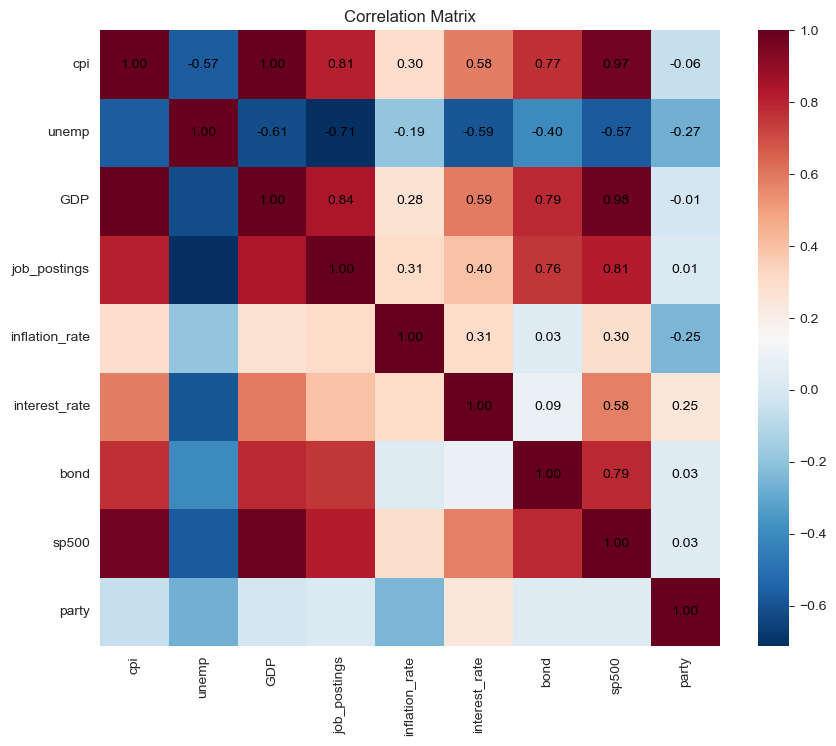

In [600]:
# Explore the correlation between variables
corr_mat = joined_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_mat, cmap='RdBu_r', ax=ax, cbar=True)

for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]): # upper triangle only
        val = corr_mat.iloc[i, j]
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix")
plt.savefig("Visualizations/CorrMat.png", dpi=300, bbox_inches="tight")
plt.show()

Interestingly, GDP and CPI has the correlation of 1.  
We can also see that GDP and S&P500 has high correlation of 0.96 CPI and S&P500 has high correlation of 0.94  
CPI and interest rate also has correlation up to 0.8

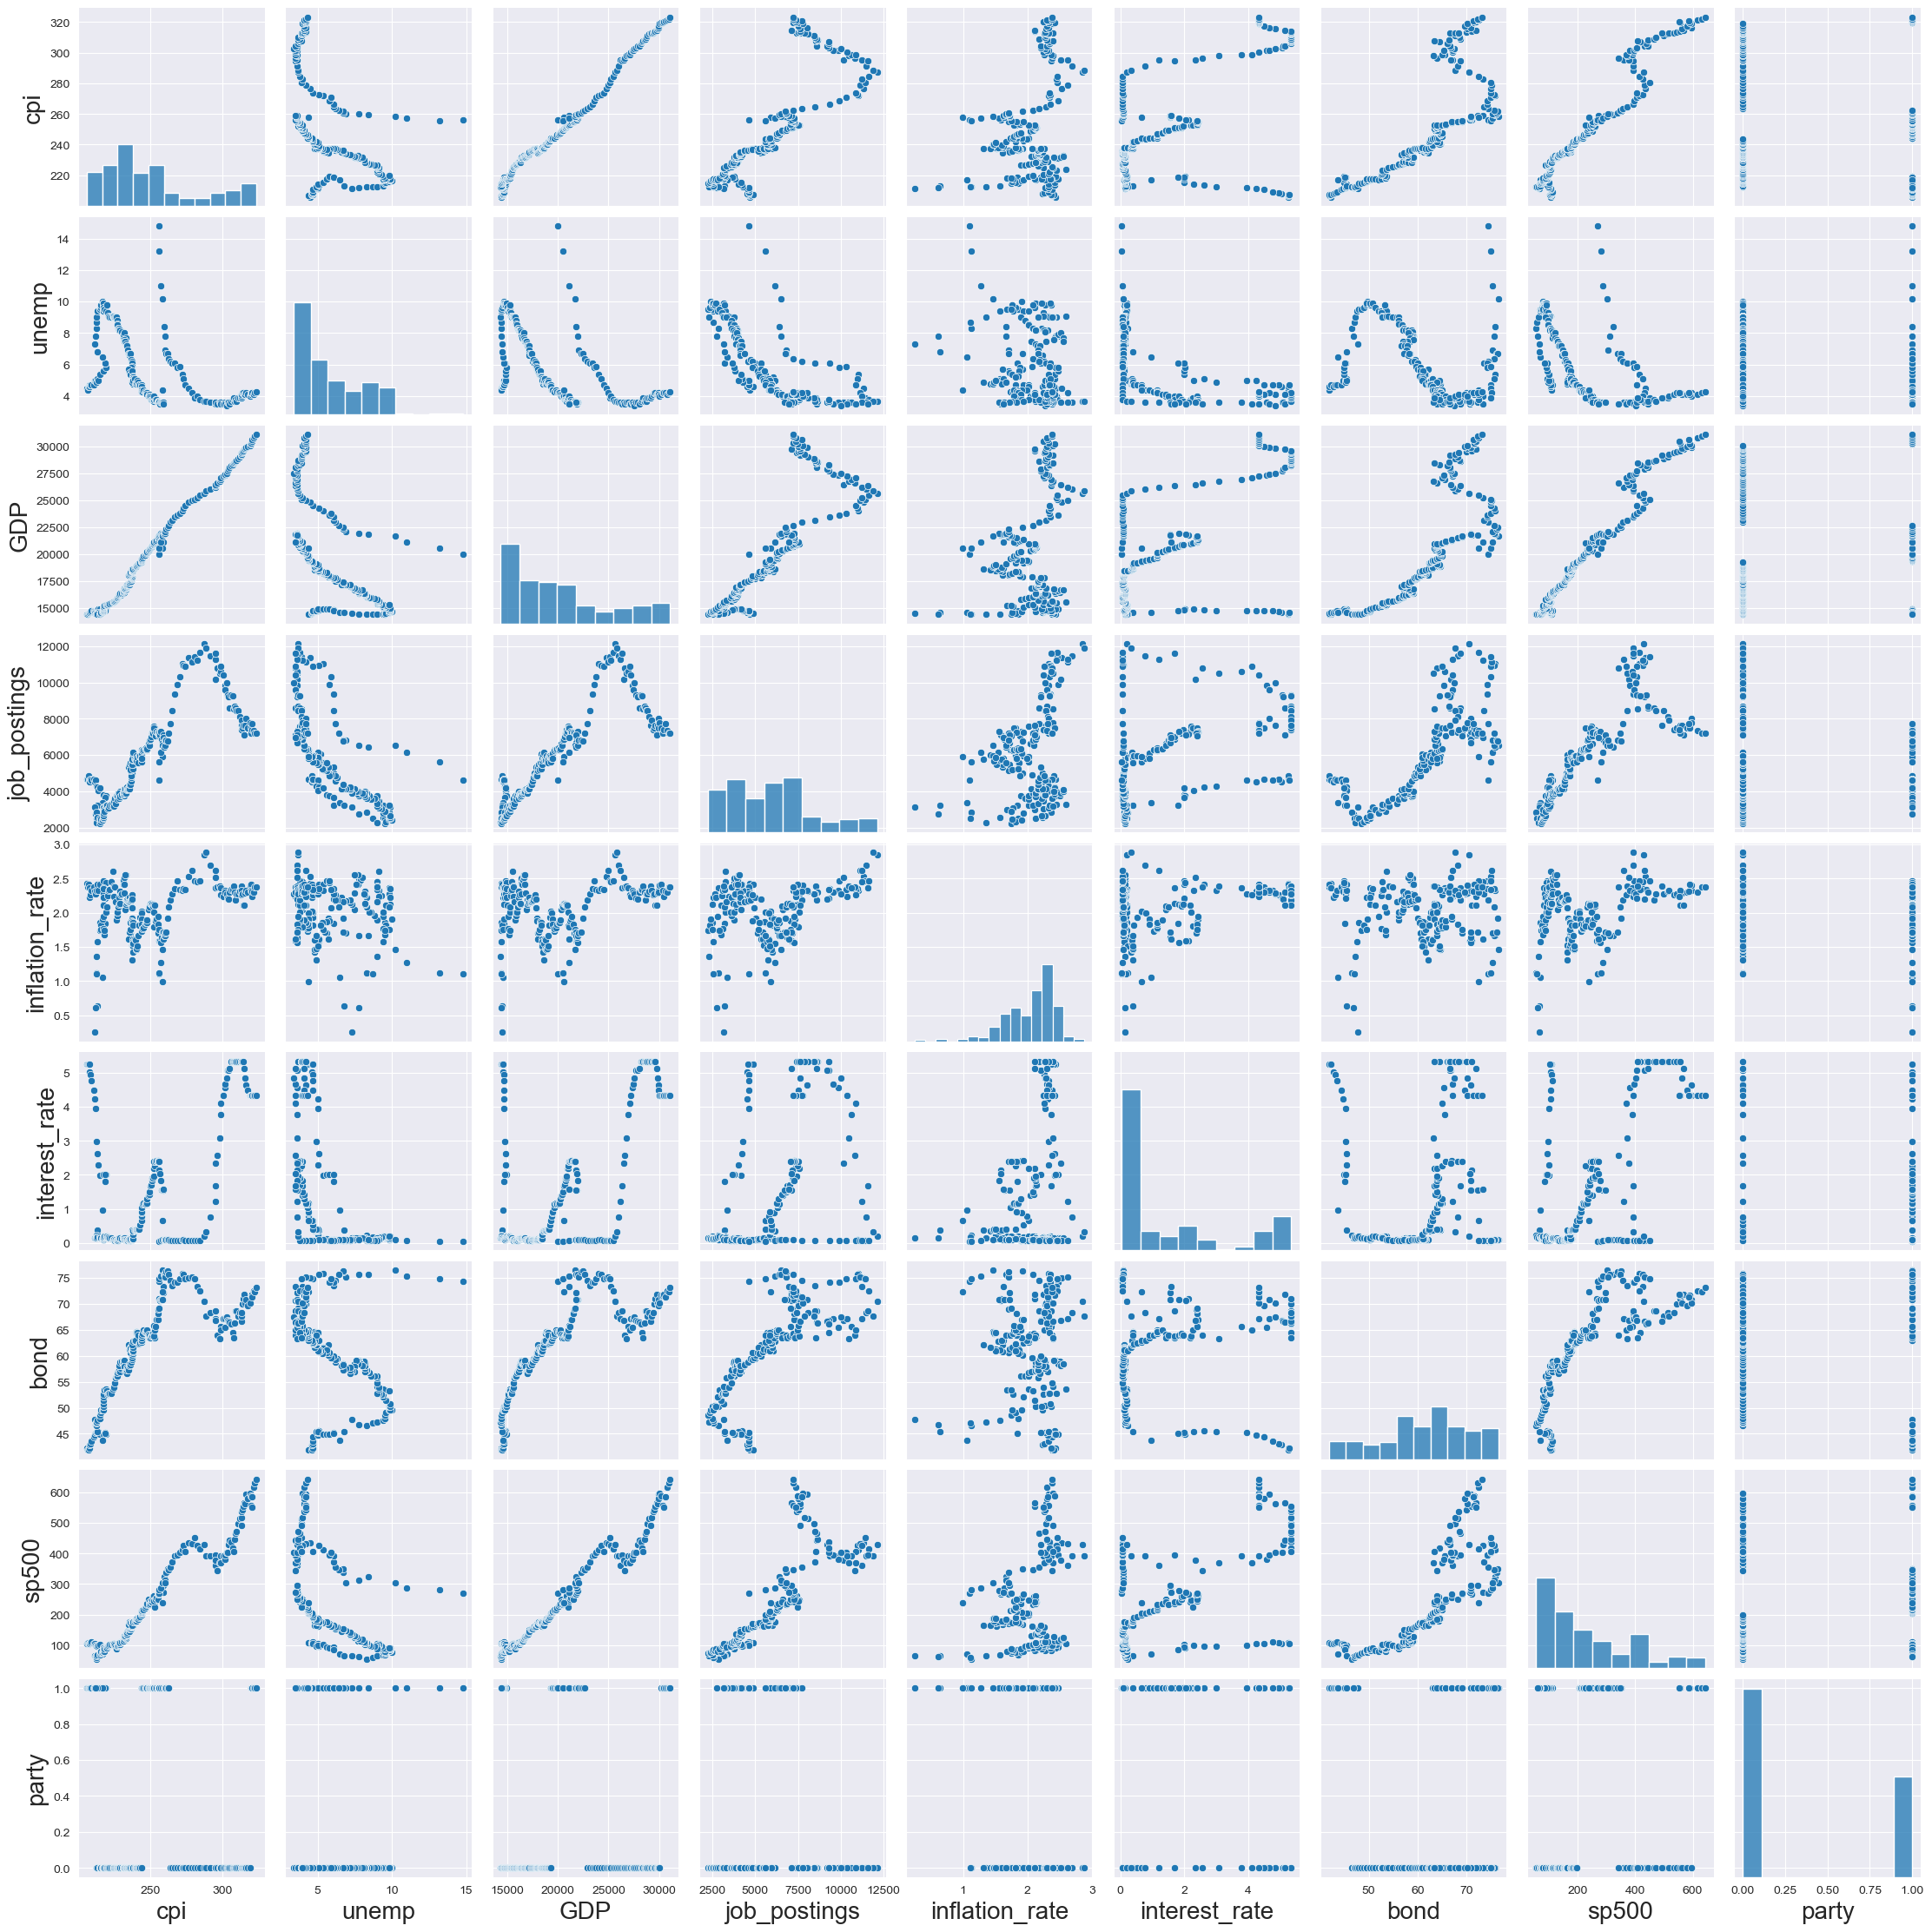

In [601]:
# Pairplots representing the relationships between variables
g = sns.pairplot(joined_df)
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.savefig("Visualizations/PairsPlot.png", dpi=300, bbox_inches="tight")
plt.show()